In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Nigeria_Food_Data.csv") 
df.head()

,Image_Path,Food_Name,Main_Ingredients,Description,Food_Health,Region
0,nigfoodai\Abacha and Ugba\-african-salad-abach...,Abacha and Ugba,"African salad, oil, fish, fermented oil bean s...",Cassava-based salad with spicy fish and fermen...,Healthy,South-East
1,nigfoodai\Abacha and Ugba\1638431539842.jpg,Abacha and Ugba,"African salad, oil, fish, fermented oil bean s...",Cassava-based salad with spicy fish and fermen...,Healthy,South-East
2,nigfoodai\Abacha and Ugba\16dc129e234cac02fdc5...,Abacha and Ugba,"African salad, oil, fish, fermented oil bean s...",Cassava-based salad with spicy fish and fermen...,Healthy,South-East
3,nigfoodai\Abacha and Ugba\2-1.jpg,Abacha and Ugba,"African salad, oil, fish, fermented oil bean s...",Cassava-based salad with spicy fish and fermen...,Healthy,South-East
4,nigfoodai\Abacha and Ugba\21276543809_b180cbd2...,Abacha and Ugba,"African salad, oil, fish, fermented oil bean s...",Cassava-based salad with spicy fish and fermen...,Healthy,South-East


In [3]:
IMG_SIZE = (224, 224)

def process_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}")
        return np.zeros((224, 224, 3))
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0 
    return img

# Apply function to all image paths in the dataset
X = np.array([process_image(img_path) for img_path in df['Image_Path']])

In [4]:
X.shape

(8969, 224, 224, 3)

In [5]:
X[0]

array([[[0.09803922, 0.63529412, 0.7372549 ],
        [0.11764706, 0.59607843, 0.69411765],
        [0.14901961, 0.53333333, 0.62745098],
        ...,
        [0.74901961, 0.68235294, 0.63137255],
        [0.76078431, 0.69803922, 0.63921569],
        [0.76862745, 0.70588235, 0.64313725]],

       [[0.16862745, 0.6627451 , 0.78039216],
        [0.19607843, 0.63921569, 0.75294118],
        [0.22745098, 0.58823529, 0.69019608],
        ...,
        [0.74117647, 0.67843137, 0.62352941],
        [0.75686275, 0.69019608, 0.63529412],
        [0.76078431, 0.69803922, 0.63529412]],

       [[0.25490196, 0.67058824, 0.82352941],
        [0.28627451, 0.66666667, 0.80784314],
        [0.30980392, 0.63137255, 0.75686275],
        ...,
        [0.7372549 , 0.67058824, 0.61960784],
        [0.74901961, 0.68235294, 0.62745098],
        [0.75294118, 0.69019608, 0.62745098]],

       ...,

       [[0.20784314, 0.16470588, 0.14901961],
        [0.21176471, 0.16862745, 0.15294118],
        [0.21960784, 0

In [6]:
# Encode categorical labels (Food Name, Region, Food Health)
label_encoders = {}
encoded_labels = {}

for col in ["Food_Name", "Region", "Food_Health"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    encoded_labels[col] = df[col].values

In [7]:
encoded_labels

{'Food_Name': array([ 0,  0,  0, ..., 22, 22, 22]),
 'Region': array([2, 2, 2, ..., 1, 1, 1]),
 'Food_Health': array([0, 0, 0, ..., 1, 1, 1])}

In [8]:
import spacy
nlp = spacy.load("en_core_web_md")

# Function to convert text to a numerical vector
def text_to_vector(text):
    return nlp(text).vector

# Apply to all descriptions
description_encoded = np.array([text_to_vector(desc) for desc in df["Description"]])
ingredients_encoded = np.array([text_to_vector(desc) for desc in df["Main_Ingredients"]])

In [9]:
description_encoded

array([[-0.76873416,  0.21350084,  0.11984374, ..., -0.39268538,
        -0.03010275,  0.0316235 ],
       [-0.76873416,  0.21350084,  0.11984374, ..., -0.39268538,
        -0.03010275,  0.0316235 ],
       [-0.76873416,  0.21350084,  0.11984374, ..., -0.39268538,
        -0.03010275,  0.0316235 ],
       ...,
       [-0.6632988 , -0.08606   ,  0.10749252, ..., -0.2661825 ,
         0.21351725, -0.18412738],
       [-0.6632988 , -0.08606   ,  0.10749252, ..., -0.2661825 ,
         0.21351725, -0.18412738],
       [-0.6632988 , -0.08606   ,  0.10749252, ..., -0.2661825 ,
         0.21351725, -0.18412738]], dtype=float32)

In [10]:
X_train, X_test, y_train_food, y_test_food = train_test_split(X, encoded_labels["Food_Name"], test_size=0.2, random_state=42)
X_train, X_test, y_train_region, y_test_region = train_test_split(X, encoded_labels["Region"], test_size=0.2, random_state=42)
X_train, X_test, y_train_health, y_test_health = train_test_split(X, encoded_labels["Food_Health"], test_size=0.2, random_state=42)
X_train, X_test, y_train_ingredients, y_test_ingredients = train_test_split(X, ingredients_encoded, test_size=0.2, random_state=42)
X_train, X_test, y_train_description, y_test_description = train_test_split(X, description_encoded, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# Output layers for each task
food_output = Dense(len(label_encoders["Food_Name"].classes_), activation="softmax", name="food_output")(x)
region_output = Dense(len(label_encoders["Region"].classes_), activation="softmax", name="region_output")(x)
health_output = Dense(len(label_encoders["Food_Health"].classes_), activation="softmax", name="health_output")(x)
ingredients_output = Dense(ingredients_encoded.shape[1], activation="linear", name="ingredients_output")(x)
description_output = Dense(description_encoded.shape[1], activation="linear", name="description_output")(x) 

model = Model(inputs=inputs, outputs=[food_output, region_output, health_output, ingredients_output, description_output])

# Compile model with specific metrics for each output
model.compile(
    optimizer="adam",
    loss={
        "food_output": "sparse_categorical_crossentropy",
        "region_output": "sparse_categorical_crossentropy",
        "health_output": "sparse_categorical_crossentropy",
        "ingredients_output": "mse",
        "description_output": "mse",
    },
    metrics={
        "food_output": "accuracy",
        "region_output": "accuracy",
        "health_output": "accuracy",
        "ingredients_output": "mae",
        "description_output": "mae",
    }
)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mobilenetv2_1.00_224          │ (None, 7, 7, 1280)        │       2,257,984 │ input_layer_1[0][0]        │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 1280)              │               0 │ mobilenetv2_1.00_224[0][0] │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1280)              │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ food_output (Dense)           │ (None, 23)                │          29,463 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ region_output (Dense)         │ (None, 5)                 │           6,405 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ health_output (Dense)         │ (None, 3)                 │           3,843 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ingredients_output (Dense)    │ (None, 300)               │         384,300 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ description_output (Dense)    │ (None, 300)               │         384,300 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,066,295 (11.70 MB)

 Trainable params: 808,311 (3.08 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history = model.fit(
    X_train,
    {
        "food_output": y_train_food,
        "region_output": y_train_region,
        "health_output": y_train_health,
        "ingredients_output": y_train_ingredients,
        "description_output": y_train_description,
    },
    validation_data=(
        X_test,
        {
            "food_output": y_test_food,
            "region_output": y_test_region,
            "health_output": y_test_health,
            "ingredients_output": y_test_ingredients,
            "description_output": y_test_description,
        },
    ),
    epochs=10,
    batch_size=32
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - description_output_loss: 0.6471 - description_output_mae: 0.6234 - food_output_accuracy: 0.3160 - food_output_loss: 2.2986 - health_output_accuracy: 0.6446 - health_output_loss: 0.8075 - ingredients_output_loss: 0.6542 - ingredients_output_mae: 0.6258 - loss: 5.6608 - region_output_accuracy: 0.4948 - region_output_loss: 1.2533 - val_description_output_loss: 0.0682 - val_description_output_mae: 0.2062 - val_food_output_accuracy: 0.6745 - val_food_output_loss: 1.0775 - val_health_output_accuracy: 0.7943 - val_health_output_loss: 0.4888 - val_ingredients_output_loss: 0.0711 - val_ingredients_output_mae: 0.2097 - val_loss: 2.4508 - val_region_output_accuracy: 0.7152 - val_region_output_loss: 0.7348
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - description_output_loss: 0.1320 - description_output_mae: 0.2841 - food_output_accuracy: 0.6705 - food_output_loss: 1.0642 - health_output_accuracy: 0.7702 - health_output_loss: 0.5218 -

In [14]:
#model save
model.save("mobilenetv2_food.h5")

In [15]:
import pickle

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [16]:
import numpy as np
import pickle

np.save("ingredients_encoded.npy", ingredients_encoded)
np.save("description_encoded.npy", description_encoded)

with open("text_data.pkl", "wb") as f:
    pickle.dump(
        {
            "ingredients": df["Main_Ingredients"].values,
            "description": df["Description"].values,
        },
        f
    )

## PREDICTION

In [17]:
import cv2
import numpy as np

IMG_SIZE = (224, 224)  # Ensure this is defined

def predict_food(image_path, model):
    img = cv2.imread(image_path)
    
    # Handle cases where the image is not found
    if img is None:
        print(f"Error: Image at path '{image_path}' not found or unreadable.")
        return None  # Return None to indicate failure

    # Resize and preprocess the image
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict using the model
    predictions = model.predict(img)

    # Process predictions
    food_pred = label_encoders["Food_Name"].inverse_transform([np.argmax(predictions[0])])[0]
    region_pred = label_encoders["Region"].inverse_transform([np.argmax(predictions[1])])[0]
    health_pred = label_encoders["Food_Health"].inverse_transform([np.argmax(predictions[2])])[0]
    ingredients_pred = predictions[3].reshape(1, -1)
    predicted_description_vector = predictions[4].reshape(1, -1)

    return food_pred, region_pred, health_pred, ingredients_pred, predicted_description_vector

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def closest_description(predicted_vector, description_vectors, descriptions):
    similarities = cosine_similarity(predicted_vector, description_vectors)
    closest_index = np.argmax(similarities)
    return descriptions[closest_index]

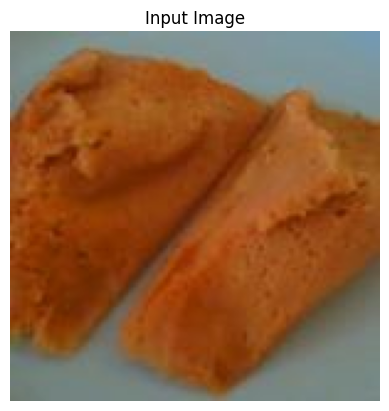

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Food Name: Moi Moi
Region: South-East
Health: Healthy
Description: Steamed bean pudding, a vegetarian delicacy
Main Ingredients: Beans, peppers, onions, spices


In [19]:
image_path = 'test/90744.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

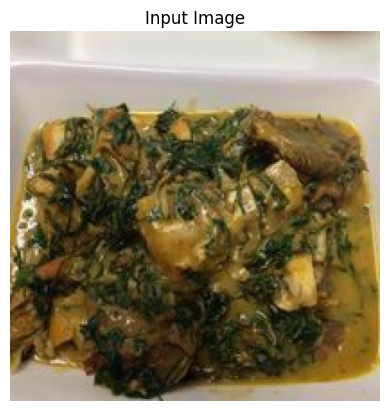

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Food Name: Efo Riro
Region: Nationwide
Health: Healthy
Description: Thick and rich soup made with ground ogbono seeds, a variety of expensive meats and offal, and vegetables
Main Ingredients: Cocoyam (thickener), Assorted meats (goat meat, cow tripe), Stockfish, Dried fish, Uziza leaves, Ugu leaves, Palm oil, Seasoning, Crayfish


In [20]:
# Example usage
image_path = 'test/un.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

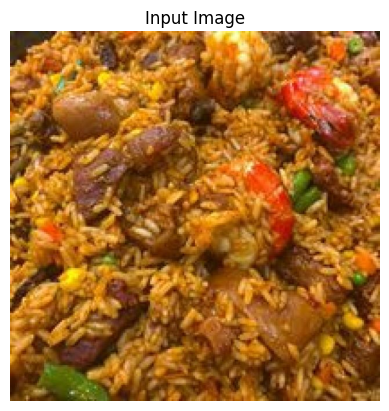

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Food Name: Jollof Rice
Region: Nationwide
Health: Moderately Healthy
Description: Thick and rich soup made with ground ogbono seeds, a variety of expensive meats and offal, and vegetables
Main Ingredients: Yam, palm oil, onions, peppers, salt, and a mixture of spices, with optional additions like smoked fish, crayfish, and green vegetables


In [21]:
# Example usage
image_path = 'test/jj.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

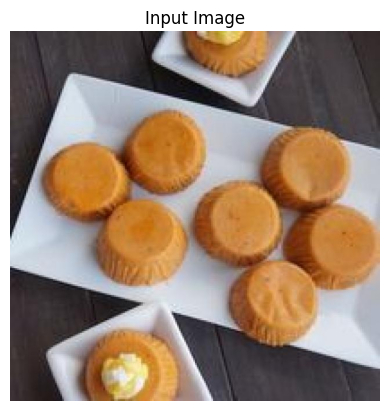

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Food Name: Moi Moi
Region: South-East
Health: Healthy
Description: Steamed bean pudding, a vegetarian delicacy
Main Ingredients: Brown beans, Palm oil, Dried peppers, Onion, Salt, Seasoning, Crayfish (optional)


In [22]:
image_path = 'test/moi.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

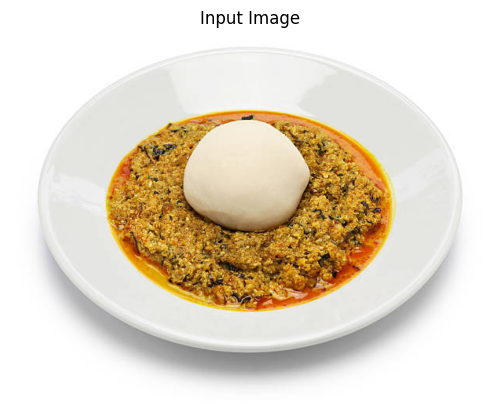

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Food Name: Egusi Soup (Full)
Region: South-West
Health: Healthy
Description: Rich and flavorful melon seed soup packed with various meats, offal, and vegetables
Main Ingredients: Egusi seeds, expensive protein (assorted meats, offal), vegetables


In [23]:
image_path = 'test/an.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

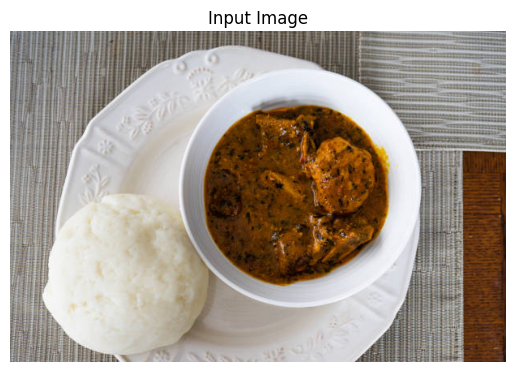

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Food Name: Ogbono Soup (Full)
Region: South-West
Health: Healthy
Description:  Soft mashed beans served with a rich spicy palm oil-based pepper sauce. A favorite street food often paired with bread or fried plantains
Main Ingredients: Rice, tomatoes, onions, peppers, chicken


In [24]:
image_path = 'test/pog.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

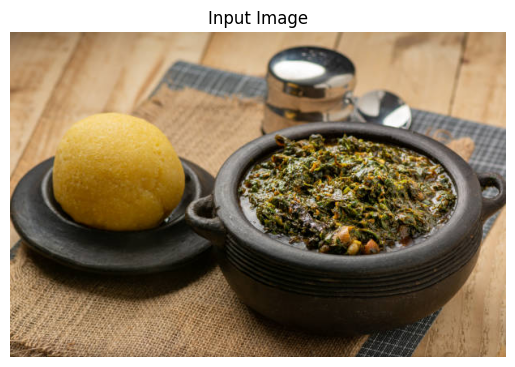

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Food Name: Okro Stew
Region: South-East
Health: Healthy
Description: A popular one-pot dish with flavorful rice and spices
Main Ingredients: Okra, tomatoes, peppers, meat, fish


In [25]:
image_path = 'test/afa.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

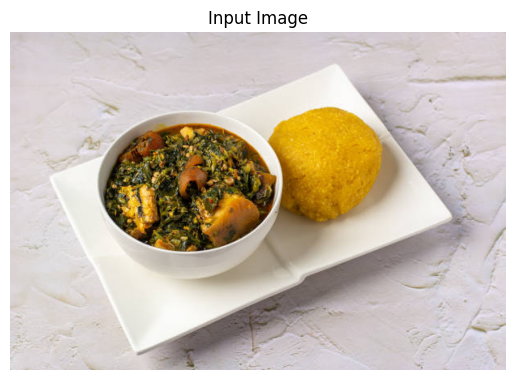

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Food Name: Okro Stew
Region: South-West
Health: Healthy
Description: A popular one-pot dish with flavorful rice and spices
Main Ingredients: Okra, tomatoes, peppers, meat, fish


In [26]:
image_path = 'test/efe.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.title("Input Image")
plt.show()

result = predict_food(image_path, model)

if result is not None:
    print("Food Name:", result[0])
    print("Region:", result[1])
    print("Health:", result[2])
    ingredient = closest_description(result[3], ingredients_encoded, df["Main_Ingredients"].values)
    predicted_desc_text = closest_description(result[4], description_encoded, df["Description"].values)
    print("Description:", predicted_desc_text)
    print("Main Ingredients:", ingredient)

In [28]:
model.save("mobilenetv2_food.keras")